
References:
    
1. Github repository of our best submission: https://github.com/alexdenker/htc2022_LPD
2. Challenge website: https://fips.fi/HTC2022.php 

Literature:

1. Learned Primal Dual: J. Adler & O. Öktem (https://arxiv.org/abs/1707.06474)
2. Multi-Scale Learned Primal Dual: A. Hauptmann et al. (https://ieeexplore.ieee.org/document/9078889)
    


In [7]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch

import odl 
from odl.contrib.torch import OperatorModule


from challenge_dataset import FullChallengeData, ChallengeData

![title](imgs/HTC.png)

## Goal 

- Provide a segmentation (material / background) of the target from limited angle CT data 
- Every method, algorithm, framework could be used 

The challenge was split into $7$ levels, starting at a $90^\circ$ angular range and going down to $30^\circ$. The angular increment was $0.5^\circ$.

| Level | Angular Range | Number of projections |
|:-----:|---------------|-----------------------|
|   1   |       90      | 181                   |
|   2   |       80      | 161                   |
|   3   |       70      | 141                   |
|   4   |       60      | 121                   |
|   5   |       50      | 101                   |
|   6   |       40      | 81                    |
|   7   |       30      | 61                    |

The specific angular subset, i.e. **the starting angle**, was only provided in the challenge phase. This mean, that our method needs to work for different subset $[\phi_1, \phi_2]$, so for different subsampling patterns of the forward operator. 


## Evaluation

The segmentation are judged based on the Matthews correlation coefficient (MCC). The MCC is in the range of $[-1, 1]$ with $+1$ a perfect segmentation, $0$ a random segmentation and $-1$ if every pixel is wrong.

## Data 

The organizers provided $5$ examples. For each example they included: 
    
1. the full view ($360^\circ$, $721$ projections) sinogram, 
2. Filtered-Backprojection reconstruction, 
3. Segmentation of FBP reconstruction 

Dimension: images $512 \times 512$, sinograms $721 \times 560$.

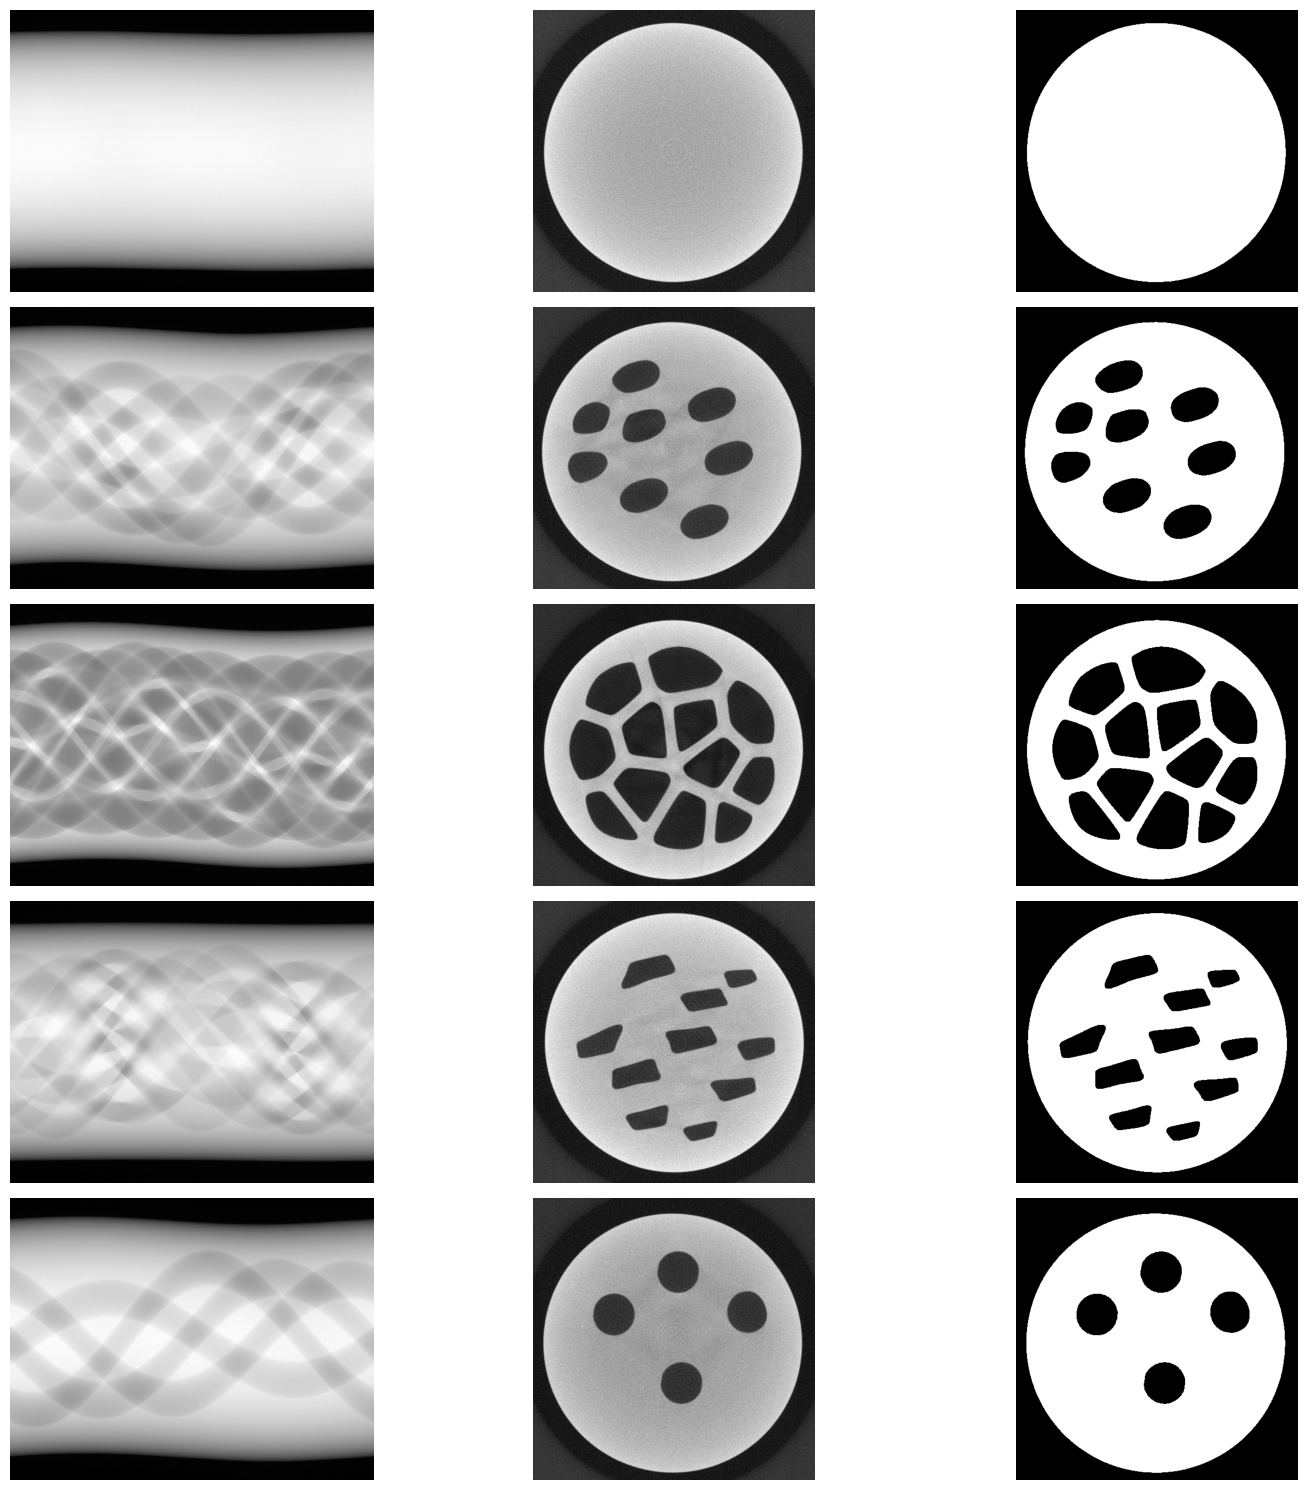

In [9]:

dataset = FullChallengeData(include_fbp=True)

fig, axes = plt.subplots(len(dataset), 3, figsize=(16,15))
for i in range(len(dataset)):

    sino, seg, fbp = dataset[i]


    axes[i, 0].imshow(sino[0,:,:].T, cmap="gray")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(fbp[0,:,:], cmap="gray")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(seg[0,:,:], cmap="gray")
    axes[i, 2].axis("off")

fig.tight_layout()
plt.show()

Note that all holes inside the object are **convex**.

## Our approach 

For each level $k \in [90^\circ, \dots, 30^\circ]$ we did the same pipeline: 

1. Build a model $A:X \to Y$ for the forward operator
2. Create synthetic phantoms $x$ 
3. Collect a dataset $(x_i, Ax_i)$ of synthetic phantoms and simulated measurements
4. Train a suitable neural network $f_\theta^k:Y \to X$ 

We used the same architecture and training setup for every level.


### How to deal with the random starting angle? 

We trained our model only on measurements of the angular rangle $[0, 30^\circ], \dots, [0, 90^\circ]$. During inference, we shifted the sinograms to start at $0\circ$, did the reconstruction + segmentation and rotated the output back to the original ortientation. 

![title](imgs/StartingAngle.png)

## Forward Operator 

We use the `odl` toolbox (which internally uses the `astra` toolbox) to create a forward operator. Using the `OperatorModule` from `odl` we get a representation of the forward opertator as a `pytorch` module (this allows us to use all autodiff functionalities). In particular, we forward operator can be used as a "layer" of a neural network.

In [10]:

def get_ray_trafo(start_angle, stop_angle, impl="astra_cuda"):  
    num_angles= 721
    det_shape = 560

    # hyperparameters in metadata of measurements
    M = 1.348414746992646 
    DistanceSourceDetector = 553.74
    DistanceSourceOrigin = 410.66
    effPixel = 0.1483223173330444

    DistanceDetectorOrigin = DistanceSourceDetector - DistanceSourceOrigin

    angle_partition = odl.uniform_partition_fromgrid(
                odl.discr.grid.RectGrid(np.linspace(0, 360, 721)*np.pi/180))[start_angle:stop_angle]
                    
    det_partition = odl.uniform_partition(-M*det_shape/2, M*det_shape/2, det_shape)

    geometry =  odl.tomo.geometry.conebeam.FanBeamGeometry(angle_partition, det_partition, 
                                                        src_radius=DistanceSourceOrigin/effPixel , 
                                                        det_radius=DistanceDetectorOrigin/effPixel,
                                                        src_to_det_init=(-1, 0))
    space = odl.discr.discr_space.uniform_discr([-256,-256], [256,256], (512, 512), dtype=np.float32)

    ray_trafo = odl.tomo.RayTransform(space, geometry, impl=impl)

    return ray_trafo


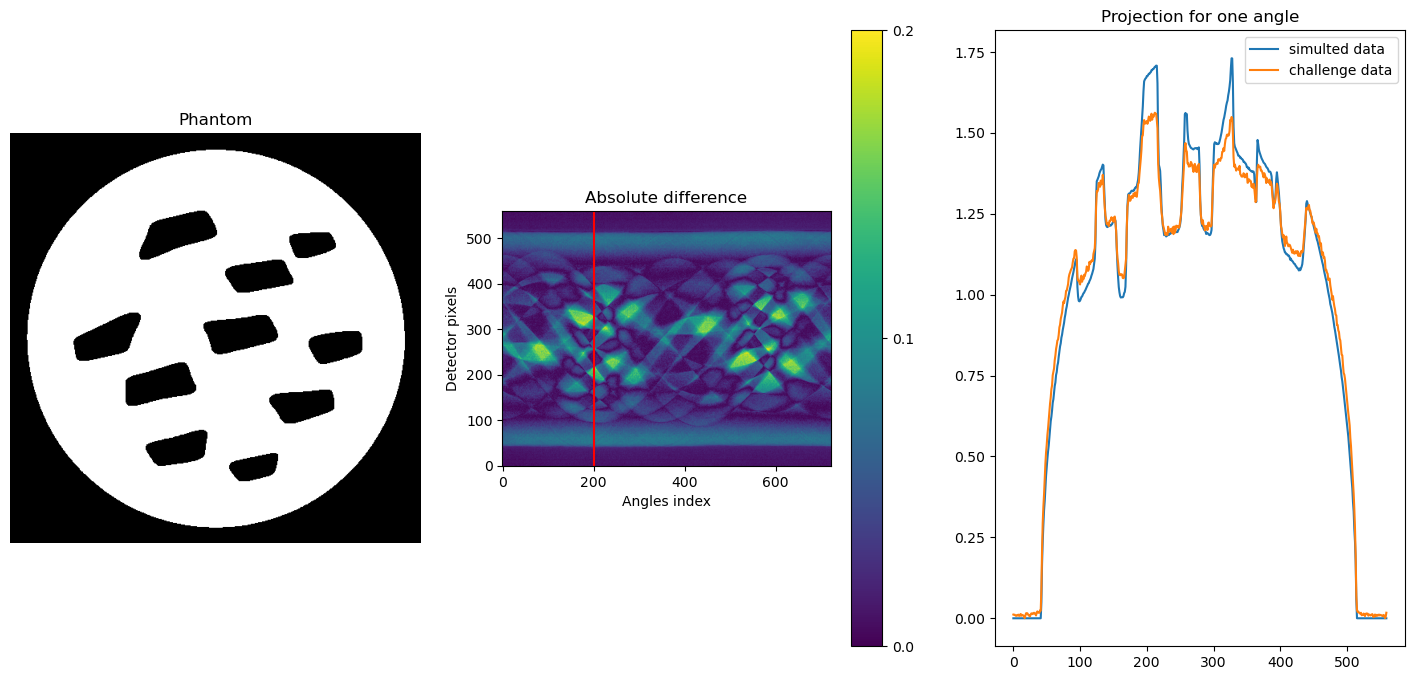

In [11]:


### build forward operator and fbp
ray_trafo = get_ray_trafo(start_angle=0, stop_angle=721)

ray_trafo_torch = OperatorModule(ray_trafo)

sino, seg, fbp = dataset[3]

phantoms = seg.unsqueeze(0)

with torch.no_grad():
    y = ray_trafo_torch(phantoms)
    y = y / torch.mean(y)

sino = sino / torch.mean(sino)

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(18,8))

ax0.imshow(seg[0,:,:], cmap="gray")
ax0.axis("off")
ax0.set_title("Phantom")

im = ax1.imshow(np.abs(y.cpu().numpy()[0,0,:,:].T - sino.cpu().numpy()[0,:,:].T), vmin=0, vmax=0.2)
cbar = fig.colorbar(im, ax=ax1, ticks=[0, 0.1, 0.2])
ax1.set_xlabel("Angles index")
ax1.set_ylabel("Detector pixels")
ax1.set_ylim(0, 560)
ax1.set_title("Absolute difference")

idx = 200
ax1.vlines(idx, 0, 560, color='r')

ax2.plot(y.cpu().numpy()[0,0,idx,:], label="simulted data")
ax2.plot(sino.cpu().numpy()[0,idx,:], label="challenge data")
ax2.legend()
ax2.set_title("Projection for one angle")
plt.show() 


They are still deviations of our simulations and the real measurement. However, for the sake of time, we just used this forward operator without corrections. 


### Example Reconstructions using the FBP defined by the approximate forward operator

Shown in red are the view angles in the angular range. Note, that angles which are orthogonal to one of the view angles can be reconstructed clearly. 

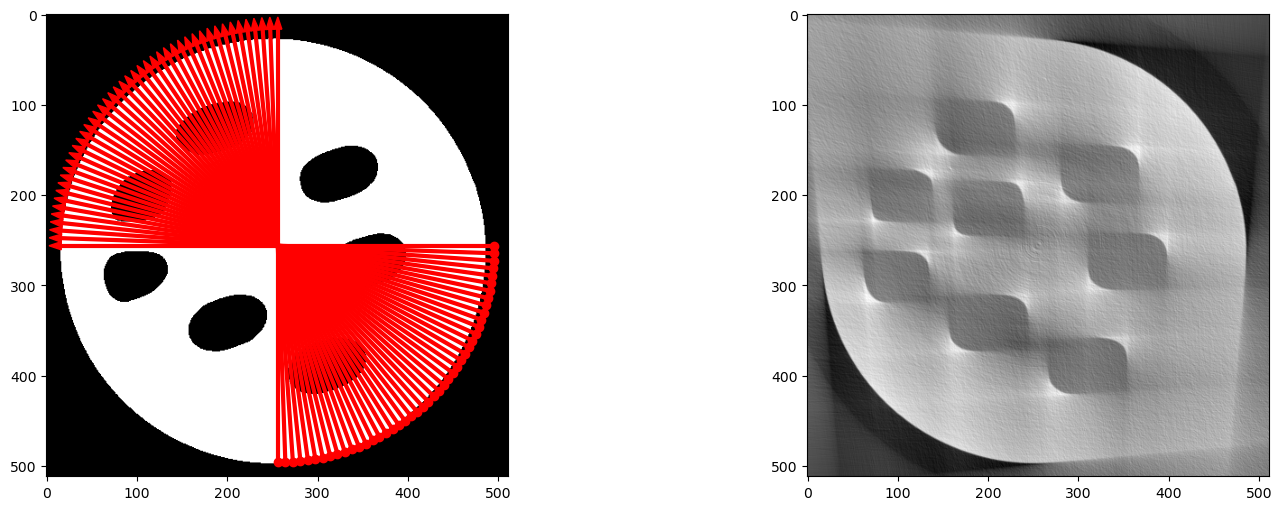

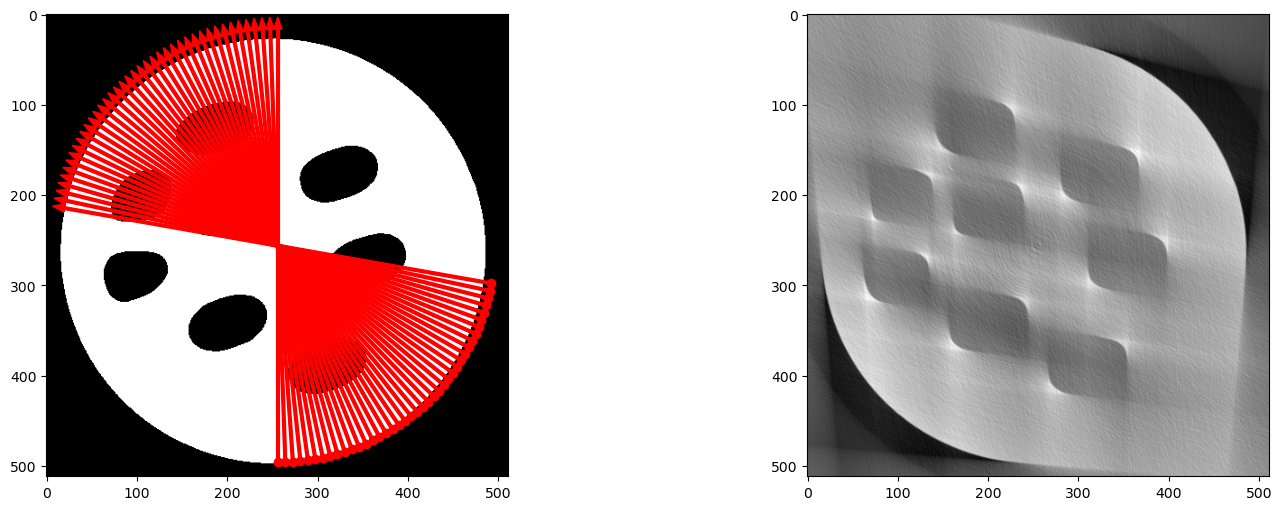

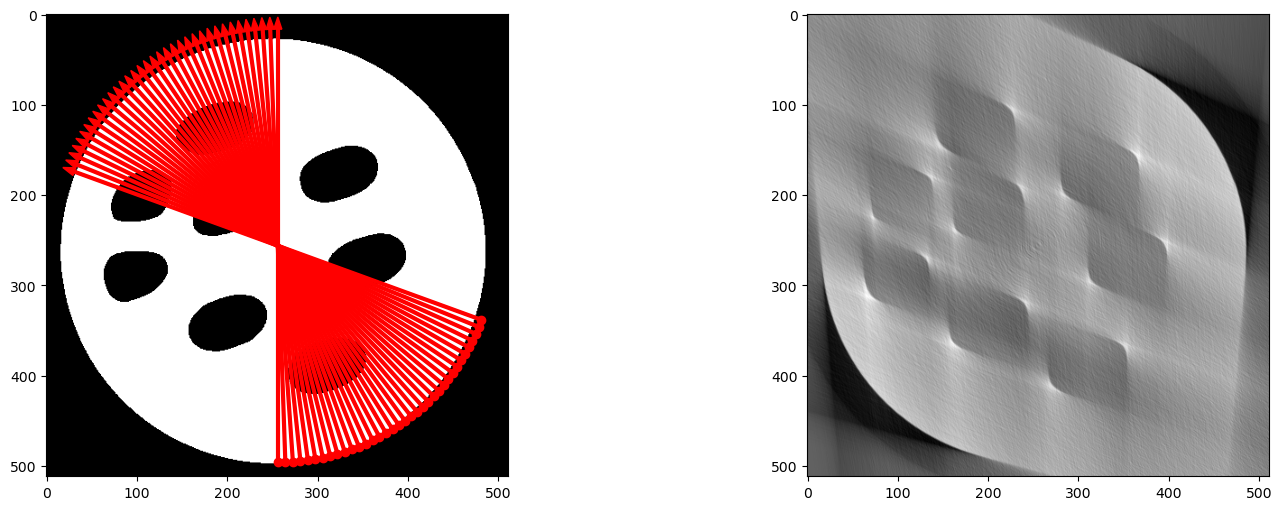

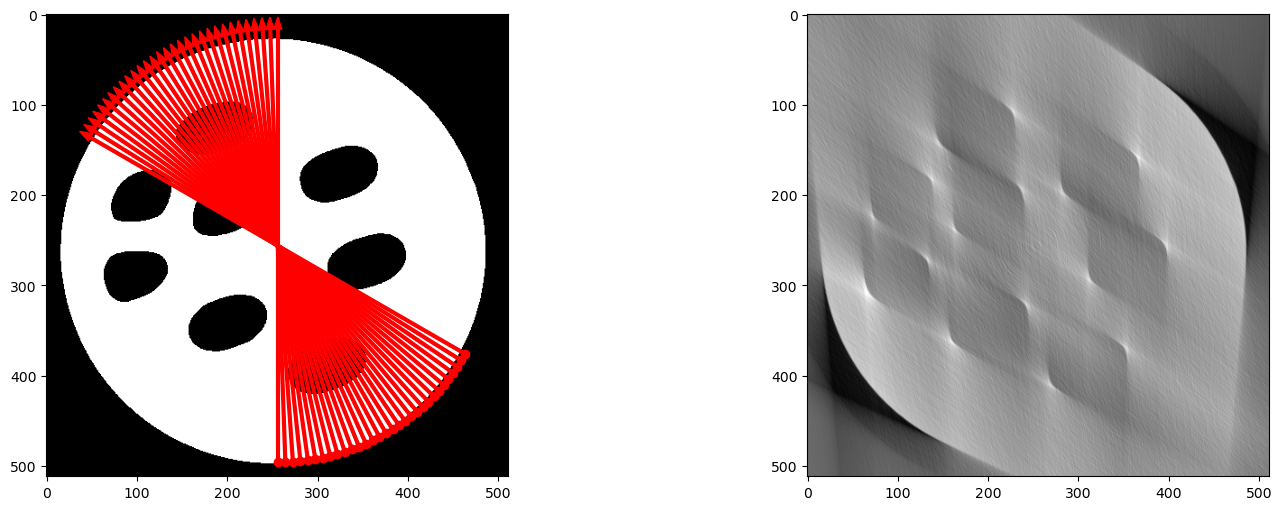

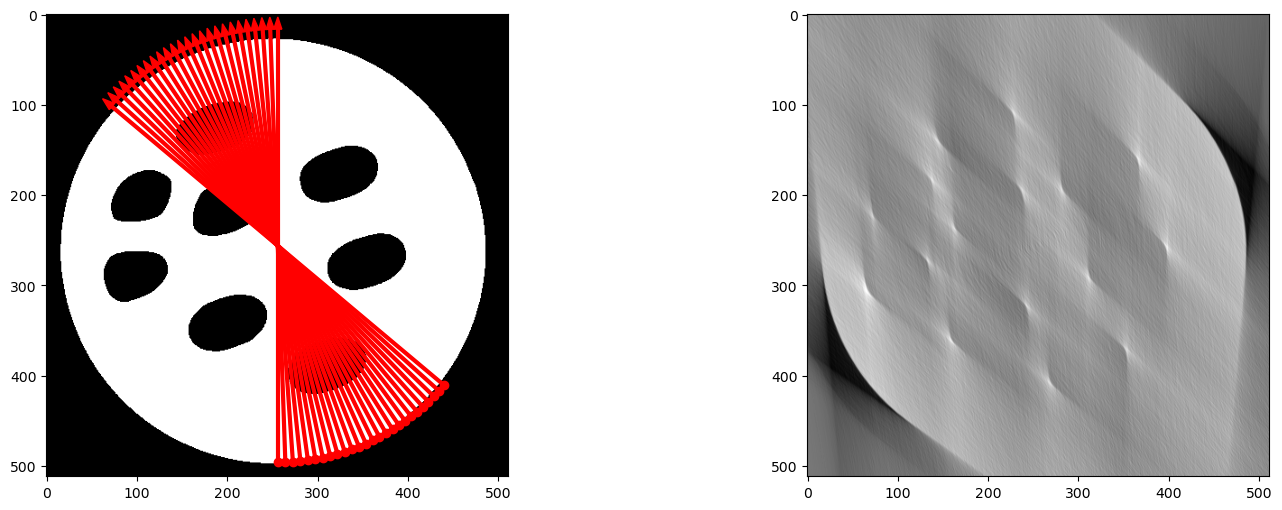

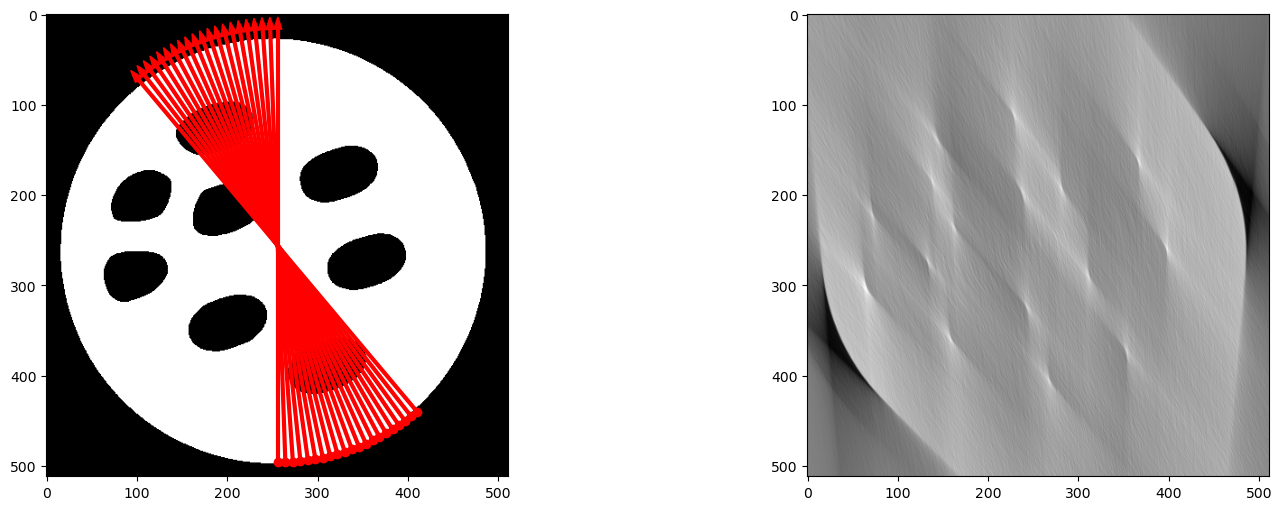

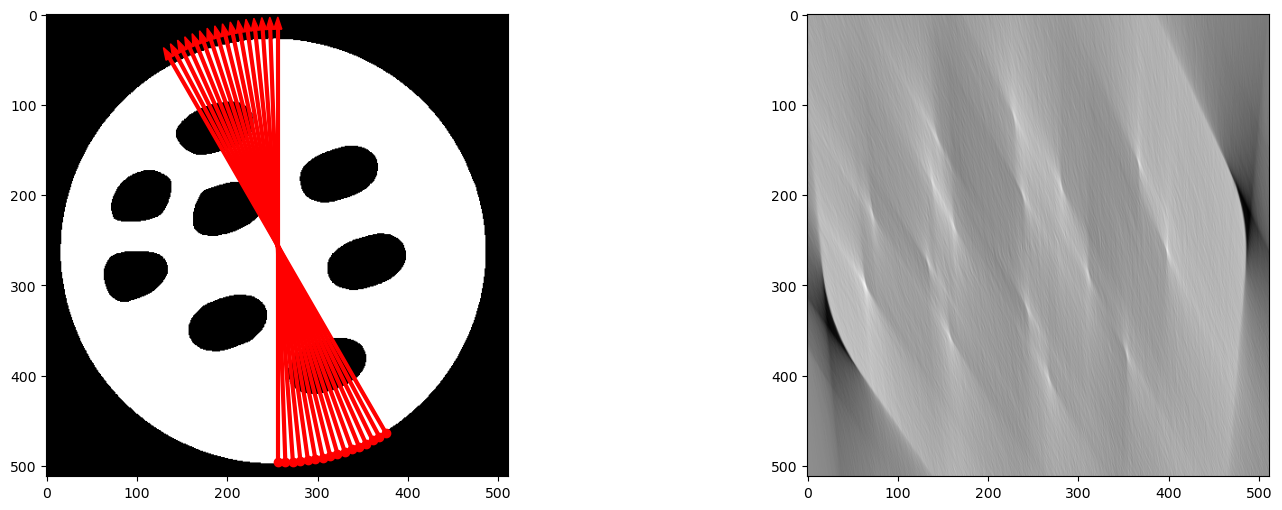

In [13]:

for angular_range in [90, 80, 70, 60, 50, 40, 30]:
    limited_angle_dataset = ChallengeData(angular_range=angular_range)

    sino, seg, angles = limited_angle_dataset[1]

    limited_angle_ray_trafo = get_ray_trafo(start_angle=angles[0], stop_angle=angles[-1])
    fbp_op = odl.tomo.analytic.filtered_back_projection.fbp_op(limited_angle_ray_trafo)
    fbp_op_torch = OperatorModule(fbp_op)


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

    ax1.imshow(seg[0,:,:], cmap="gray")

    fbp_reco = fbp_op_torch(sino)

    ax2.imshow(fbp_reco[0,:,:], cmap="gray")

    def get_line(phi, u, t=np.linspace(-1.5,1.5,150)):
        return u*np.array([[-np.sin(phi - np.pi/2)],[np.cos(phi - np.pi/2)]]) + t * np.array([[-np.sin(phi)], [np.cos(phi)]])


    for phi in limited_angle_ray_trafo.geometry.angles[0::4]:
        line = get_line(-phi, 0, t=-np.linspace(-240,240,10))

        ax1.plot(line[0,:]+256, line[1,:]+256, c="r",lw=3,ls="-")
        ax1.scatter(line[0,0]+256, line[1,0]+256, c="r")
        ax1.arrow(line[0,0]+256, line[1,0]+256, line[0,-1] - line[0,0] , line[1,-1] - line[1,0] ,
                  color="r", width=1.5,head_width=9)
    plt.show()

## Syntetic dataset

We assumed that the challenge phantoms would also be disk of the same size with holes. So, we implemented four ways to create random holes:

1. Non-overlapping circles
2. Non-overlapping polygones
3. Crossing lines 
4. Level sets of Gaussians

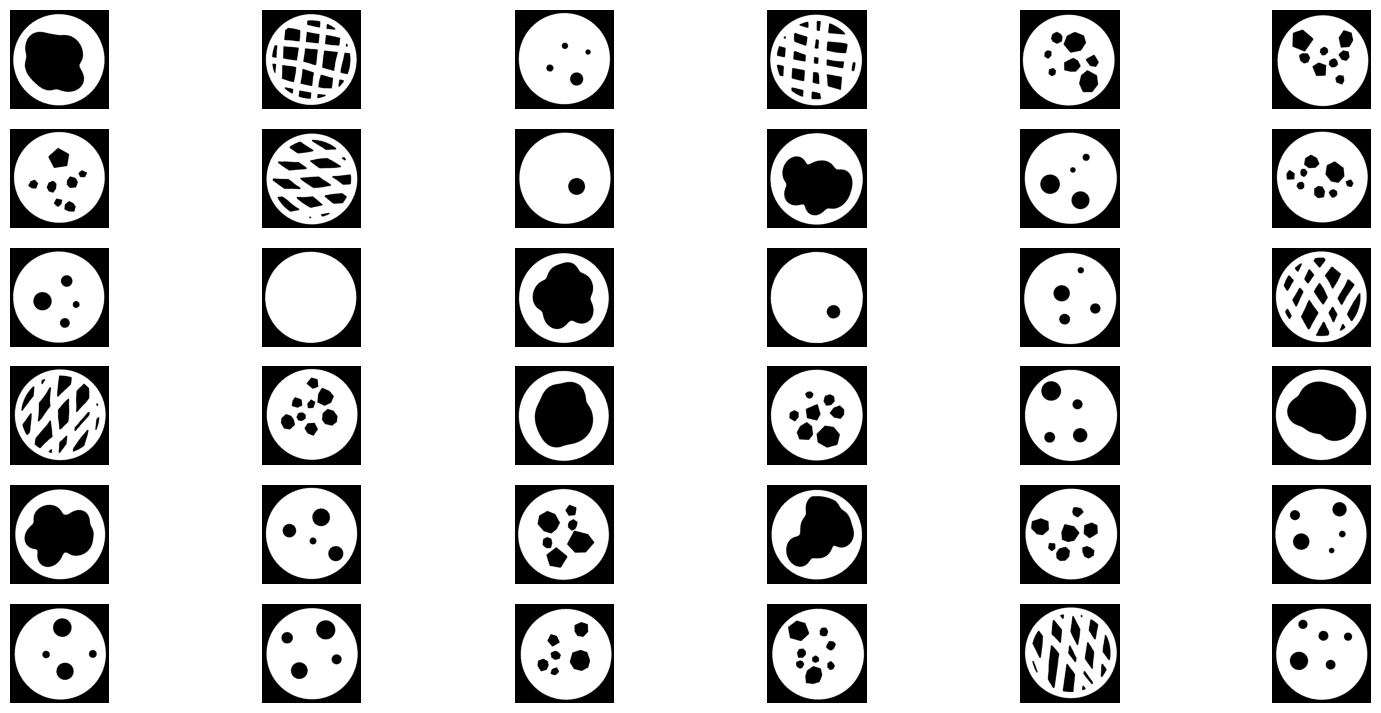

In [17]:
from sim_dataset import SimulatedPhantom

dataset = SimulatedPhantom(subset="train", rotate=True, data_generation_methods=["phantom_1", "phantom_2", "phantom_3", "phantom_4"],
            data_generation_probability=[2.25, 2.5, 3, 1.1], length=200, max_iter=80)
fig, axes = plt.subplots(6,6, figsize=(19,9))

for idx, ax in enumerate(axes.ravel()):
    phantoms_seg, phantoms = dataset[idx]
    ax.imshow(phantoms_seg[0,:,:], cmap="gray")
    ax.axis("off")
plt.show()

## Neural Network: Learned Primal Dual

Primal-Dual algorithm was introduced by Chambolle & Pock for convex optimization problems:

$$ \min_x F(Ax) + G(x)  $$

with $F:Y \to [0, +\infty]$ and $G:X \to [0, +\infty]$ being convex. For $\sigma, \tau > 0$ and $x_0, \bar{x}_0 \in X, y_0 \in Y, \theta \in [0,1]$ the primal-dual algorithm is defined by:

$$ y_{i+1} = \text{prox}_{\sigma F^*}(y_i + \sigma A \bar{x}_i) \\ 
   x_{i+1} = \text{prox}_{\tau G}(x_i - \tau A^* y_{i+1} ) \\
   \bar{x}_{i+1} = x_{i+1} + \theta (x_{i+1} - x_{i}) $$ 
   
   
The idea of Adler & Öktem for Learned Primal Dual was to unroll this algorithm for $N$ steps and replace all proximal mappings with neural networks. Further, they introduced additional memory channels:

$$ (y_{i+1}, h^Y_{i+1}) = \text{NN}_{\theta^d_i}(y_i, A x_i, y, h^Y_i) \\ 
   (x_{i+1}, h^X_{i+1}) = \text{NN}_{\theta^p_i}(x_i, A^* y_{i+1}, h^X_i) \\ 
   i = 0, \dots, N-1$$
   

with $x_N(y)$ as the final reconstruction. We choose $x_0 = A^\dagger y$ and $y_0 = 0$. 

Here $\text{NN}_{\theta^d_i}: Y \times Y \times Y \times Y^M \to Y \times Y^M$, $\text{NN}_{\theta^p_i}: X \times X \times X^M \to X \times X^M$ are seperate neural network for each unrolling step. The network is then usually trained by minimizing the mean squared error on a dataset $(x^k, y^k)_{k=1}^K$:

$$ \min_{\theta^p_0, \dots, \theta^p_{N-1}, \theta^d_{0}, \dots, \theta^d_{N-1}} \frac{1}{K} \sum_{k=1}^K \| x^k - x_N(y^k) \|_2^2$$

Note: We lose all convergence & stability results from primal-dual. We use the unrolling of primal-dual just as a motivation for a suitable neural network architecture. There is a way of getting some convergence results back, i.e. by using deep equilibrium networks, but we did not follow this route. 

Empiricially, this network also works well, if the operator $A$ and the adjoint $A^*$ are just approximations of the true operator. Even more, this network often works even better if we use some pseudo-inverse instead of the adjoint $A^*$. In our experiment we replace $A^*$ with the filtered back-projection $A^\dagger$. 

## Our Modifications

The original implementation of learned primal dual used rather small CNNs in each step. We used larger CNNs, based on the UNet architecture, but reduced the number of unrolling iterations. Additional, we added a larger UNet at the end of the unrolling schemes which takes in the last iterate and all memory variables to create a final segmentation. 

In particular, we choose $N=4$ unrolling iterations: 

$$ (y_{i+1}, h^Y_{i+1}) = \text{NN}_{\theta^d_i}(y_i, A x_i, y, h^Y_i) \\ 
   (x_{i+1}, h^X_{i+1}) = \text{UNet}_{\theta^p_i}(x_i, A^* y_{i+1}, h^X_i) \\ 
   i = 0, \dots, 3 \\
   \hat{x}(y) = \text{UNet}_{\theta}(x_4, h^X_4)$$
   
   
The model was then trained by minimizing the binary cross entropy loss over the synthetic dataset:

$$ \min_{\theta, \theta^p_0, \dots, \theta^p_{N-1}, \theta^d_{0}, \dots, \theta^d_{N-1}} \frac{1}{K} \sum_{k=1}^K \text{BCE}(x^k,\hat{x}(y^k))$$


Training with synthetic data and finetuning with challenge examples.

Results

In [19]:
from torchvision.transforms.functional import rotate


from lpd_unet import SegmentationPrimalDualNet
import yaml 
import os 

In [21]:
step_to_angular_idx = {
    1: 181,
    2: 161,
    3: 141,
    4: 121,
    5: 101,
    6: 81,
    7: 61
}

step_to_angular_range = {
    1: 90,
    2: 80,
    3: 70,
    4: 60,
    5: 50,
    6: 40,
    7: 30
}

categoryNbr = 1

limited_angle_dataset = ChallengeData(angular_range=step_to_angular_range[categoryNbr])

sino, seg, angles = limited_angle_dataset[1]


# 1. load ray_trafo  
ray_trafo = get_ray_trafo(0, step_to_angular_idx[categoryNbr])
fbp_op = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo, frequency_scaling=0.75, filter_type='Hann')

ray_trafo_torch = OperatorModule(ray_trafo)
fbp_op_torch = OperatorModule(fbp_op)

### create file structure
version_num = 0
path_parts = ["network_weights", "range=" + str(step_to_angular_range[categoryNbr]), "version_" + str(version_num)]
log_dir = os.path.join(*path_parts)

with open(os.path.join(log_dir, "hparams.yml"), 'r') as h_file:
    hparams = yaml.safe_load(h_file)

model = SegmentationPrimalDualNet(n_iter=hparams["n_iter"], 
                            op=ray_trafo_torch, 
                            op_adj=fbp_op_torch, 
                            n_primal=hparams["n_primal"], 
                            n_dual=hparams["n_dual"], 
                            use_sigmoid=hparams["use_sigmoid"], 
                            n_layer=hparams["n_layer"],
                            internal_ch=hparams["internal_ch"], 
                            kernel_size=hparams["kernel_size"], 
                            batch_norm=hparams["batch_norm"],
                            normalize_sinogram=hparams["normalize_sinogram"])

model.load_state_dict(torch.load(os.path.join(log_dir, "model.pt"),  map_location=torch.device('cpu')))
model.eval()

SegmentationPrimalDualNet(
  (op): OperatorModule(RayTransform) ((512, 512) -> (181, 560))
  (op_adj): OperatorModule(OperatorComp) ((181, 560) -> (512, 512))
  (op_init): OperatorModule(OperatorComp) ((181, 560) -> (512, 512))
  (primal_blocks): ModuleList(
    (0): UNet(
      (down): ModuleList(
        (0): DownBlock(
          (conv): Sequential(
            (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): GroupNorm(8, 32, eps=1e-05, affine=True)
            (3): LeakyReLU(negative_slope=0.2, inplace=True)
            (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (5): GroupNorm(8, 32, eps=1e-05, affine=True)
            (6): LeakyReLU(negative_slope=0.2, inplace=True)
            (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (8): GroupNorm(8, 32, eps=1e-05, affine=True)
         

In [22]:
sum(p.numel() for p in model.parameters())

2433733

In [11]:


y = torch.from_numpy(sinogram).unsqueeze(0).unsqueeze(0).float().to(device)





with torch.no_grad():
    x_hat = torch.sigmoid(model(y))
    filter = threshold_otsu(x_hat.cpu().numpy()[0,:,:,:])

#print(filter)
x_seg = rotate(x_hat, angles[0]).cpu().detach().numpy()[0,0,:,:]
x_seg[x_seg < filter] = 0.
x_seg[x_seg >= filter] = 1.

mask = np.ones([7,7])
mask[0,[0,-1]]=0
mask[-1,[0,-1]]=0
x_seg = binary_closing(x_seg, structure=mask)

im = Image.fromarray(x_seg*255.).convert("L")

os.makedirs(outputFolder, exist_ok=True)
im.save(os.path.join(outputFolder,f.split(".")[0] + ".PNG"))




NameError: name 'sinogram' is not defined

## Things which didnt go to plan...


### Silent Bugs 

While preparing the jupyter notebook, I came across a bug in my code. Because of this, all memory channels in the image space are always equal to the current iterate. So, essentially our learned primal dual network does not have any memory channels for the primal space.   

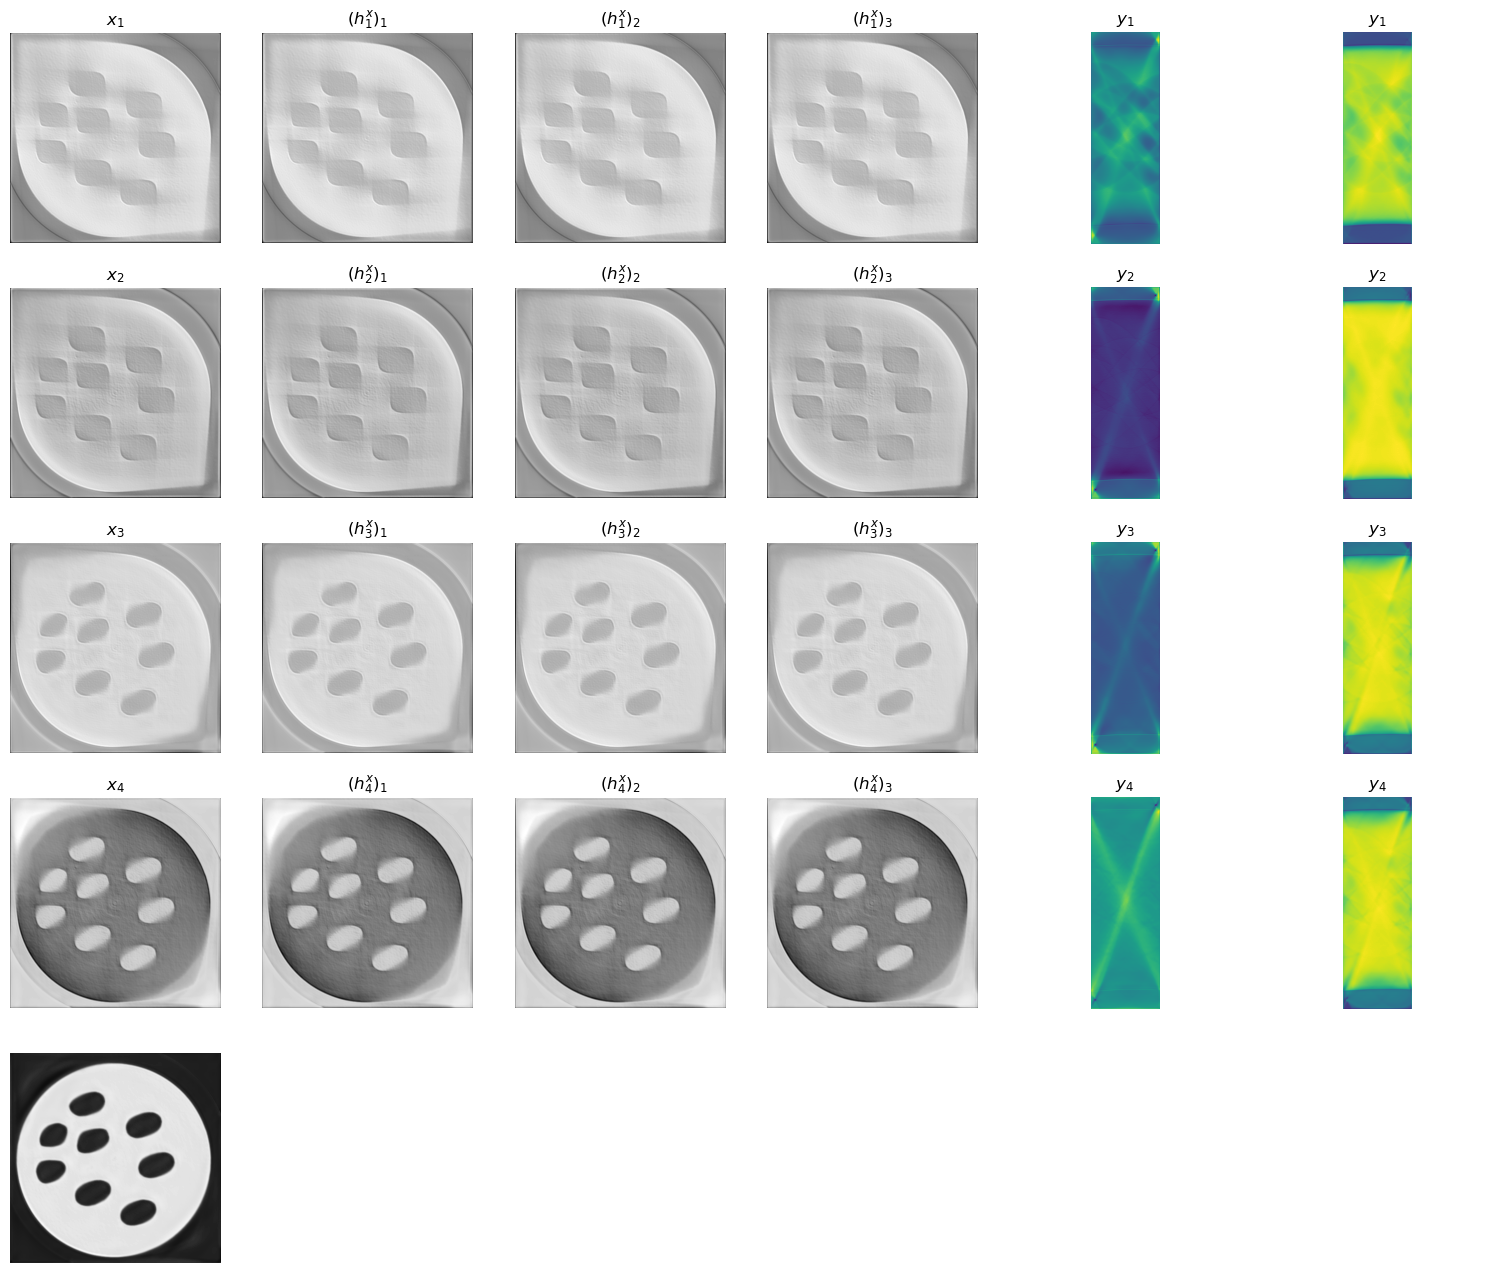

In [23]:
sino, seg, angles = limited_angle_dataset[1]


sino = sino.unsqueeze(0)

with torch.no_grad():
    x_list, y_list = model.forward_full(sino)

    

fig, axes = plt.subplots(len(x_list), x_list[0].shape[1] + y_list[0].shape[1], figsize=(19,16))

for i in range(len(y_list)):
    
    axes[i, 0].imshow(x_list[i][0,0,:,:], cmap="gray")
    axes[i, 0].set_title(r"$x_{}$".format(i+1))
    
    axes[i, 1].imshow(x_list[i][0,1,:,:], cmap="gray")
    axes[i, 1].set_title(r"$(h^x_{})_1$".format(i+1))
    axes[i, 2].imshow(x_list[i][0,2,:,:], cmap="gray")
    axes[i, 2].set_title(r"$(h^x_{})_2$".format(i+1))
    axes[i, 3].imshow(x_list[i][0,3,:,:], cmap="gray")
    axes[i, 3].set_title(r"$(h^x_{})_3$".format(i+1))
    
    axes[i, 4].imshow(y_list[i][0,0,:,:].T)
    axes[i, 4].set_title(r"$y_{}$".format(i+1))
    axes[i, 5].imshow(y_list[i][0,1,:,:].T)
    axes[i, 5].set_title(r"$y_{}$".format(i+1))

for ax in axes.ravel():
    ax.axis("off")

axes[-1, 0].imshow(x_list[-1][0,0,:,:], cmap="gray")
    
plt.show()

### Parameters of the random Gaussian level sets produced often to simple holes 

Also, the other methods only produced convex holes. 

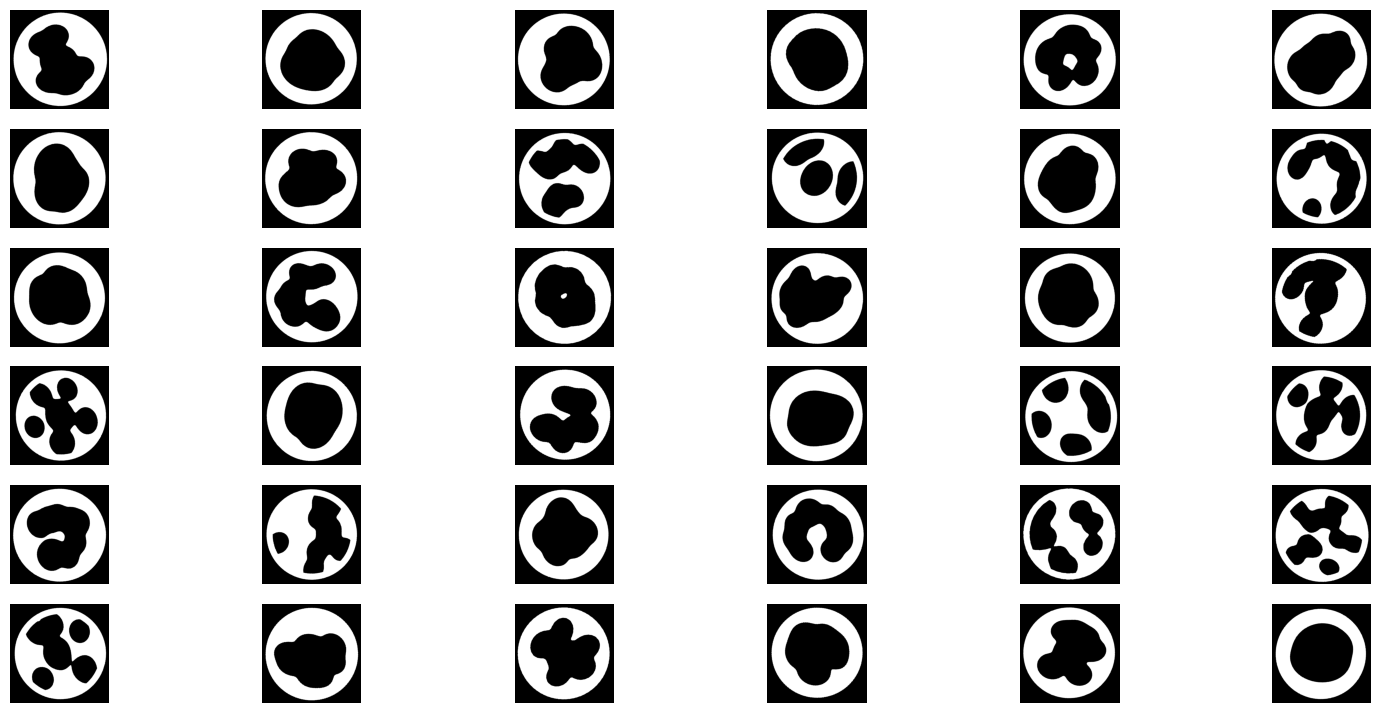

In [25]:
from sim_dataset import SimulatedPhantom

dataset = SimulatedPhantom(subset="train", rotate=True, data_generation_methods=["phantom_1", "phantom_2", "phantom_3", "phantom_4"],
            data_generation_probability=[0, 0, 0, 1], length=200, max_iter=80)
fig, axes = plt.subplots(6,6, figsize=(19,9))

for idx, ax in enumerate(axes.ravel()):
    phantoms_seg, phantoms = dataset[idx]
    ax.imshow(phantoms_seg[0,:,:], cmap="gray")
    ax.axis("off")
plt.show()